# Surface Hoar Exploration - Sublimation of Snow Campaign
---------------------------------------
### Daniel Hogan
### University of Washington


In [1]:
from soslib import funcs
import xarray as xr
import nctoolkit as nc
import numpy as np
import pytz
import datetime as dt

import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'nctoolkit'

### Pull in SOS data from FTP server for a specific date

In [2]:
study_dates = ['20230113','20230114','20230115']
# for i, study_date in enumerate(study_dates):
#     if i == 0:
#         ds = nc.open_url(f'ftp://ftp.eol.ucar.edu/pub/archive/isfs/projects/SOS/netcdf/noqc_geo/isfs_{study_date}.nc').to_xarray()
#     if len(study_dates) > 1:
#         tmp = nc.open_url(f'ftp://ftp.eol.ucar.edu/pub/archive/isfs/projects/SOS/netcdf/noqc_geo/isfs_{study_date}.nc').to_xarray()
#         ds = xr.concat([ds,tmp], dim='time')
# nc.clean_all()

In [ ]:
ds.Rsw_in_9m_d

In [3]:
dates = np.arange(20230113,20230116,1)
dss = []
for date in dates:
    dss.append(nc.open_url(f'ftp://ftp.eol.ucar.edu/pub/archive/isfs/projects/SOS/netcdf/noqc_geo/isfs_{date}.nc').to_xarray()[['Rpile_out_9m_d',
                                                                                                                                'Tcase_out_9m_d', 
                                                                                                                                'Vpile_d', 
                                                                                                                                'Vtherm_d', 
                                                                                                                                'IDir_d',
                                                                                                                                'Vpile_c',
                                                                                                                                'Vtherm_c', 
                                                                                                                                'IDir_c',
                                                                                                                                'Vpile_uw',
                                                                                                                                'Vtherm_uw', 
                                                                                                                                'IDir_uw',
                                                                                                                                'Vpile_ue',
                                                                                                                                'Vtherm_ue', 
                                                                                                                                'IDir_ue',
                                                                                                                                'Tsnow_0_4m_d',
                                                                                                                                'Tsnow_0_5m_d',
                                                                                                                                'Tsnow_0_6m_d',
                                                                                                                                'Rsw_in_9m_d',
                                                                                                                                'Rsw_out_9m_d']])
                                                                                                                                

NameError: name 'np' is not defined

### Import RADSYS data from NOAA SPLASH

In [5]:
study_dates_radsys = [s[0:4]+'-'+s[4:6]+'-'+s[6:] for s in study_dates]
radsys_ds = funcs.get_daily_radsys_data(study_dates_radsys[0], study_dates_radsys[-1])


https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp23013.dat
https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp23014.dat
https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp23015.dat


Import SAIL surface energy data

In [8]:
SIGMA = 5.67e-8 # Stephan-Boltzmann constant

# information that is needed to use functions
username = 'dlhogan@uw.edu'
token = '7f1c805e6ae94c21'
# products
sebs = 'gucsebsM1.b1'
surf = 'gucgndirtM1.b1'
# start and end
start = '2023-01-13'
end = '2023-01-15'


# grab SAIL surface data
ds_surface = funcs.get_sail_data(username, token, surf, start, end)
# grab SAIL surface energy balance data
ds_sebs = funcs.get_sail_data(username, token, sebs, start, end)
# grab SPLASH Radsys data
ds_radsys = funcs.get_daily_radsys_data(start,end)

[DOWNLOADING] gucgndirtM1.b1.20230113.000000.nc
                             
[DOWNLOADING] gucgndirtM1.b1.20230114.000000.nc
                             
[DOWNLOADING] gucgndirtM1.b1.20230115.000000.nc
                             
[DOWNLOADING] gucsebsM1.b1.20230113.000000.cdf
                             
[DOWNLOADING] gucsebsM1.b1.20230114.000000.cdf
                             
[DOWNLOADING] gucsebsM1.b1.20230115.000000.cdf
                             
https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp23013.dat
https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp23014.dat
https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp23015.dat


### Function for apogee correction 
- UW does not work well here

In [6]:
# functions I will need 
def apogee2temp(dat,tower):
# hard-coded sensor-specific calibrations
    Vref = 2.5
    ID = dat[f"IDir_{tower}"]
    sns = [136, 137, 138, 139]
    im = [ sns.index(x) if x in sns else None for x in ID ][0]
# unclear if we want these, or scaled up versions
    mC0 = [57508.575,56653.007,58756.588,58605.7861][im] * 1e5
    mC1 = [289.12189,280.03380,287.12487,285.00285][im] * 1e5
    mC2 = [2.16807,2.11478,2.11822,2.08932][im] * 1e5
    bC0 = [-168.3687,-319.9362,-214.5312,-329.6453][im]* 1e5
    bC1 = [-0.22672,-1.23812,-0.59308,-1.24657][im]* 1e5
    bC2 = [0.08927,0.08612,0.10936,0.09234][im]* 1e5
# read data
    Vtherm = dat[f"Vtherm_{tower}"]
    Vpile = dat[f"Vpile_{tower}"]*1000
# calculation of detector temperature from Steinhart-Hart
    Rt = 24900.0/((Vref/Vtherm) - 1)
    Ac = 1.129241e-3
    Bc = 2.341077e-4
    Cc = 8.775468e-8
    TDk = 1/(Ac + Bc*np.log(Rt) + Cc*(np.log(Rt)**3))
    TDc = TDk - 273.15
# finally, calculation of "target" temperature including thermopile measurement
    m = mC2*TDc**2 + mC1*TDc + mC0
    b = bC2*TDc**2 + bC1*TDc + bC0
    TTc = (TDk**4 + m*Vpile + b)**0.25 - 273.15
    # sufs = suffixes(TTc,leadch='') # get suffixes
    # dimnames(TTc)[[2]] = paste0("Tsfc.Ap.",sufs)
    TTc = TTc
    return TTc

def addlocaltime(ds):
    time_utc = ds['time'].to_index().tz_localize(pytz.UTC)
    us_mtn = pytz.timezone('US/Mountain')
    tz_corrected = time_utc.tz_convert(us_mtn).tz_localize(None)
    ds.coords.update({'local_time':tz_corrected})
    return ds

### Add surface temperatures to the dataset

In [73]:
ds_sos = xr.concat(dss, dim='time')

ds_sos= ds_sos.assign(TsurfLW = ((ds_sos.Rpile_out_9m_d + (ds_sos.Tcase_out_9m_d+273.15)**4*SIGMA)/SIGMA/0.98)**0.25 - 273.15)
ds_sos = ds_sos.assign(Tsurfapogee_d=apogee2temp(ds_sos,'d'))
ds_sos = ds_sos.assign(Tsurfapogee_c=apogee2temp(ds_sos,'c'))
ds_sos = ds_sos.assign(Tsurfapogee_uw=apogee2temp(ds_sos,'uw'))
ds_sos = ds_sos.assign(Tsurfapogee_ue=apogee2temp(ds_sos,'ue'))

In [14]:
ds_sebs['Tsurf'] = ((ds_sebs['up_long']/SIGMA/0.98)**0.25 - 273.15).resample(time='30min').mean()
ds_radsys['Tsurf'] = ((ds_radsys['uw_ir']/SIGMA/0.98)**0.25 - 273.15).resample(time='30min').mean()

- Can you see a change in the albedo or directional reflectance from any of the sensors when there’s clearly surface hoar under the sensor?
- What about the thermal signal in the various IR and longwave sensors?  This morning seems a good chance to figure out how the sensors each “observe” surface hoar.

### Looking for changes in albedo or directional reflectance

In [41]:
night_mask = [0,1,2,3,4,5,6,7,8,15,16,17,18,19,20,21,22,23]
# radsys albedo 
radsys_out_solar = radsys_ds.where((radsys_ds['uw_solar_qc']==0) & (radsys_ds['dw_solar_qc']==0))['uw_solar']
radsys_in_solar = radsys_ds.where((radsys_ds['uw_solar_qc']==0) & (radsys_ds['dw_solar_qc']==0))['dw_solar']

albedo_radsys = addlocaltime(radsys_out_solar/radsys_in_solar)
albedo_radsys = albedo_radsys.where(~albedo_radsys.local_time.dt.hour.isin(night_mask))

# sail albedo
sail_up_solar = ds_sebs.where((ds_sebs['qc_up_short_hemisp']==0) & (ds_sebs['qc_down_short_hemisp']==0))['up_short_hemisp']
sail_down_solar = ds_sebs.where((ds_sebs['qc_up_short_hemisp']==0) & (ds_sebs['qc_down_short_hemisp']==0))['down_short_hemisp']

albedo_sail = addlocaltime(sail_down_solar/sail_up_solar)
albedo_sail = albedo_sail.where(~albedo_sail.local_time.dt.hour.isin(night_mask))

# sos albedo
sos_in_solar = ds_sos['Rsw_in_9m_d']
sos_out_solar = ds_sos['Rsw_out_9m_d']

albedo_sos = addlocaltime(sos_out_solar/sos_in_solar)
albedo_sos = albedo_sos.where(~albedo_sos.local_time.dt.hour.isin(night_mask))


Text(0.5, 1.0, 'Albedo for 20230113-20210114\nSurface hoar observed on the 14th')

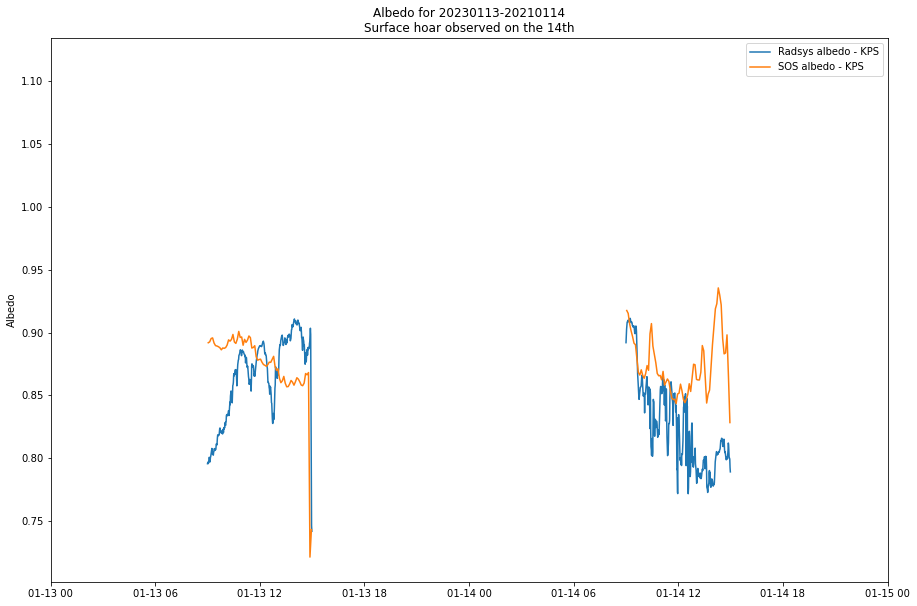

In [47]:
fig, ax = plt.subplots(1,1, figsize=(15,10))

ax.plot(albedo_radsys.local_time, albedo_radsys, label='Radsys albedo - KPS')
# SAILs appears wonky
# ax.plot(albedo_sail.local_time, albedo_sail, label='SAIL albedo - Gothic')
ax.plot(albedo_sos.local_time, albedo_sos, label='SOS albedo - KPS')
ax.legend()
ax.set_xlim(dt.date(2023,1,13),dt.date(2023,1,15))
ax.set_ylabel('Albedo')
ax.set_title('Albedo for 20230113-20210114\nSurface hoar observed on the 14th')


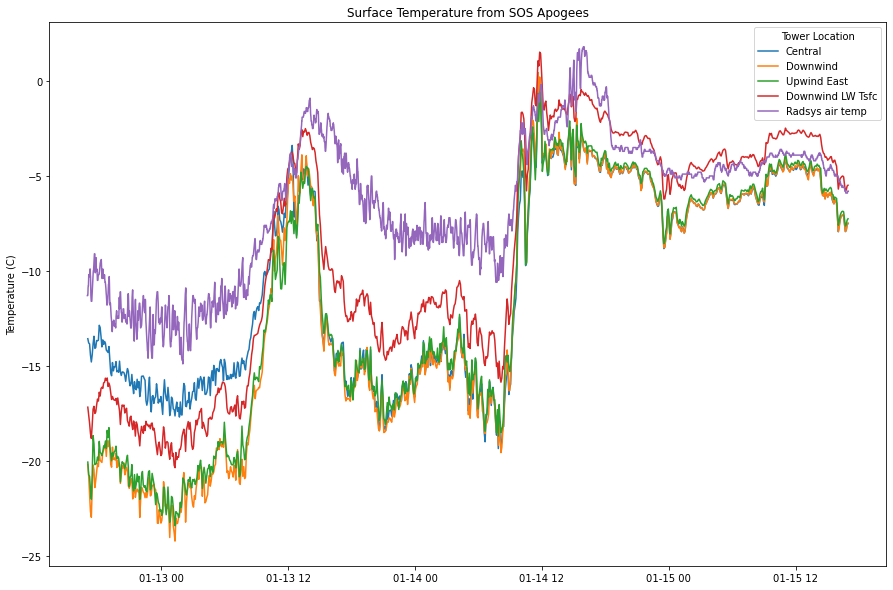

In [74]:
ds_sos = addlocaltime(ds_sos)
fig, ax = plt.subplots(1,1,figsize=(15,10))

ax.plot(ds_sos.local_time,ds_sos.Tsurfapogee_c, label='Central')
ax.plot(ds_sos.local_time,ds_sos.Tsurfapogee_d, label='Downwind')
ax.plot(ds_sos.local_time,ds_sos.Tsurfapogee_ue, label='Upwind East')
ax.plot(ds_sos.local_time, ds_sos.TsurfLW, label='Downwind LW Tsfc')
ax.plot(ds_radsys.local_time, ds_radsys.AirTemp, label='Radsys air temp')
ax.set_title('Surface Temperature from SOS Apogees')
ax.set_ylabel('Temperature (C)')
ax.legend(title='Tower Location')

In [56]:
from numpy.fft import fft, rfft
from scipy.signal import spectrogram

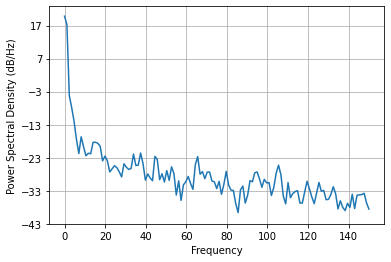

In [68]:
data = ds_sos.sel(time=slice('2023-01-14 12','2023-01-14 13'))
central_apogee = ds_sos['Tsurfapogee_c'].values.reshape(-1)         # Extract the EEG variable
t = data.time.values                   # ... and the t variable

x = central_apogee                               # Relabel the data variable
dt =300                  # Define the sampling interval
plt.psd(x,Fs=dt);

In [71]:
nc.open_url('ftp://ftp.eol.ucar.edu/pub/archive/isfs/projects/SOS/to_Eli/sos.1m.Z.nc').to_xarray()

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'h5netcdf', 'scipy', 'rasterio', 'zarr']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html